In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img

In [24]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [25]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'

nTrain = 600
nVal = 150

In [30]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,3))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

Found 600 images belonging to 3 classes.


In [31]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,3))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 150 images belonging to 3 classes.


### Create your own model and train the network

In [32]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 600 samples, validate on 150 samples
Epoch 1/20
600/600 [==============================] - 0s - loss: 2.2658 - acc: 0.5583 - val_loss: 0.9076 - val_acc: 0.6267
Epoch 2/20
600/600 [==============================] - 0s - loss: 0.4247 - acc: 0.8533 - val_loss: 0.7782 - val_acc: 0.7133
Epoch 3/20
600/600 [==============================] - 0s - loss: 0.3868 - acc: 0.8567 - val_loss: 0.4165 - val_acc: 0.8333
Epoch 4/20
600/600 [==============================] - 0s - loss: 0.2655 - acc: 0.9100 - val_loss: 0.4703 - val_acc: 0.8667
Epoch 5/20
600/600 [==============================] - 0s - loss: 0.1497 - acc: 0.9367 - val_loss: 0.5814 - val_acc: 0.8467
Epoch 6/20
600/600 [==============================] - 0s - loss: 0.0710 - acc: 0.9717 - val_loss: 0.3836 - val_acc: 0.8867
Epoch 7/20
600/600 [==============================] - 0s - loss: 0.1263 - acc: 0.9567 - val_loss: 0.3535 - val_acc: 0.9067
Epoch 8/20
600/600 [==============================] - 0s - loss: 0.0308 - acc: 0.9933 - val_l

In [33]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.iteritems())

In [34]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

 32/150 [=====>........................] - ETA: 0s

In [35]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 14/150


### Let us see which images were predicted wrongly

Original label:pumpkin, Prediction :tomato, confidence : 0.953


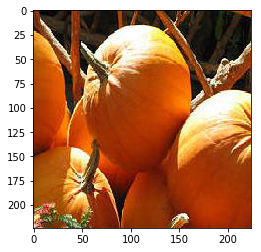

Original label:pumpkin, Prediction :tomato, confidence : 0.975


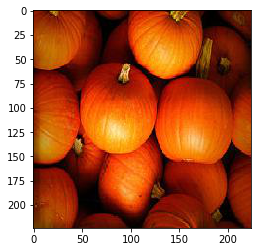

Original label:pumpkin, Prediction :tomato, confidence : 0.695


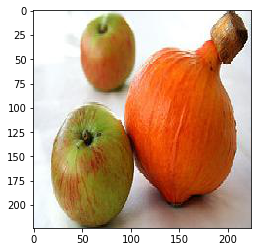

Original label:pumpkin, Prediction :watermelon, confidence : 0.502


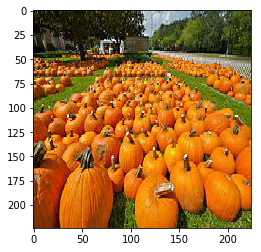

Original label:pumpkin, Prediction :watermelon, confidence : 0.987


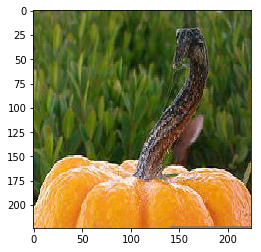

Original label:tomato, Prediction :pumpkin, confidence : 1.000


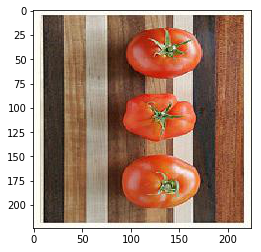

Original label:tomato, Prediction :watermelon, confidence : 1.000


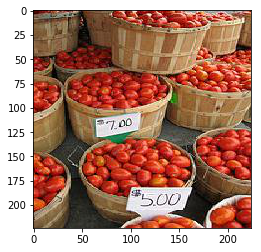

Original label:tomato, Prediction :pumpkin, confidence : 0.982


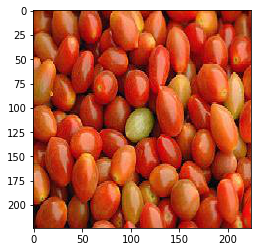

Original label:tomato, Prediction :pumpkin, confidence : 1.000


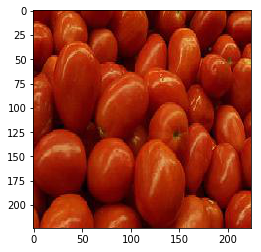

Original label:watermelon, Prediction :pumpkin, confidence : 0.984


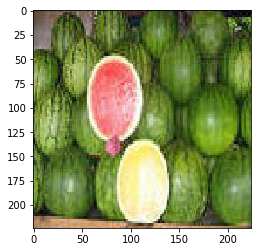

Original label:watermelon, Prediction :pumpkin, confidence : 0.963


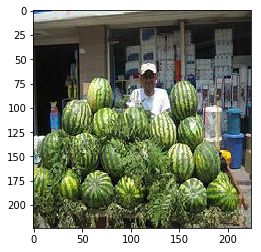

Original label:watermelon, Prediction :pumpkin, confidence : 0.935


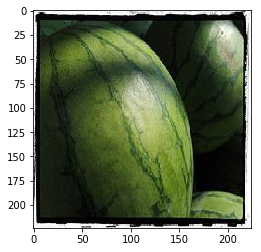

Original label:watermelon, Prediction :tomato, confidence : 0.762


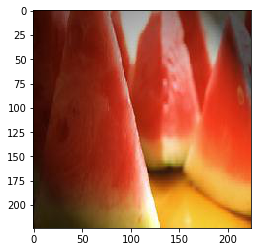

In [18]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()